In [4]:
!pip3 install tdmclient --upgrade

In [13]:
import tdmclient.notebook
await tdmclient.notebook.stop()

In [14]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_filter

# Import tdmclient Notebooks environment:

#await tdmclient.notebook.start()

# Functions

In [7]:
@tdmclient.notebook.sync_var 
def set_position(x, y):
    global position
    position[0] = x
    position[1] = y

@tdmclient.notebook.sync_var 
def set_target(x, y):
    global target
    target[0] = x
    target[1] = y


@tdmclient.notebook.sync_var 
def set_arrive(arr):
    global arrived
    arrived = arr

@tdmclient.notebook.sync_var
def get_arrive():
    global arrived
    return arrived


# Main Thymio Code 

In [8]:
%%run_aseba
# robot position
var position[2] = 0,0
# robot direction
var direction[2] = 0,0
# target position
var target[2] = 0,0
# robot to target vector
var targetdir[2] = 0,0
# robot direction
var teta = 0
#robot direction relative to the target
# alpha[0] -> cos alpha
# alpha[1] -> sin alpha
var alpha[2] = 0,0
# distance to target
var distance = 0
# speed
var speedf = 100
var speedr = 100
var mindist = 30
var angletolerance = 2
var deltadirection[2] = 0,0
# boolean to know if the robot arrived at the target
var arrived = 0

# activates each 100 ms
timer.period[0] = 500  
# activates each 1000 ms
timer.period[1] = 100 




# on timer0 event, we update the direction of the robot and it's motor speeds
onevent timer0
    # calculate the difference between the target and the current position
    # to get the direction vector
    call math.sub(direction, target, position)
    # calculate alpha (angle between the robot direction and the target direction)
    call math.dot(alpha[0], targetdir, direction, 0)
    deltadirection[0] = direction[0]
    deltadirection[1] = -direction[1]
    call math.dot(alpha[1], targetdir, deltadirection,0)
    # calculate the distance to the target ()
    if direction[0] < 0 then
        distance = -direction[0]
    end
    if direction[1] < 0 then
        distance = -direction[1]
    end
    # manhattan distance, to avoid overflow in the the multiplication
    distance = direction[0] + direction[1]
    #call math.sqrt(distance, distance)  
    # if the robot direction vector is close to the target direction vector
    if alpha[1] < angletolerance or alpha[1] > -angletolerance then
        alpha[1] = 0
    end
    
onevent timer1
    if distance < mindist then
        motor.left.target = 0
        motor.right.target = 0
        arrived = 1
    else 
        # goal is forward
        if alpha[0] >= 0 then
            # update the motor speeds, alpha[1] will determine the turning force
            motor.left.target = speedf + speedr * alpha[1]
            motor.right.target = speedf - speedr * alpha[1]
        # goal is backward, need to turn
        elseif alpha[0] < 0 then
            if alpha[1] > 0 then
                # turn left
                motor.left.target = -speedf - speedr * alpha[1]
                motor.right.target = speedf + speedr * alpha[1]
            elseif alpha[1] < 0 then
                # turn right
                motor.left.target = speedf - speedr * alpha[1]
                motor.right.target = -speedf + speedr * alpha[1]
            end
        end
    end 

# Overseer Code

## Camera and Computer Vision setup

1
2
3
4
5
6
7
8
9
10
11
Either the robot or the goal is not visible/detectable
obstacles
[(918, 405), (1023, 408), (1027, 522), (920, 515), (891, 467)]
[(378, 289), (368, 333), (182, 310), (190, 285)]
[(997, 140), (820, 219), (969, 259), (933, 211)]
[(1104, 125), (1007, 322), (738, 270), (922, 100)]
[(478, 160), (678, 35), (705, 267), (671, 74)]
robot
[]
goal
[]


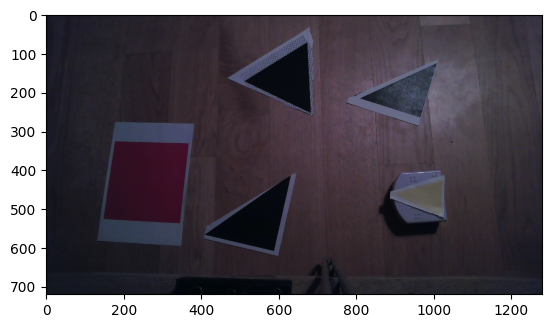

In [20]:
#read_camera(-7)
obst, robot, goal, frame = cv_start(show_image= True)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)
print("obstacles")
for o in obst:
    print(o)

print("robot")
print(robot)
print("goal")
print(goal)

## Augmented Dijkstra

path
[243 174]
[329 337]
[661 117]
[812 201]
[984 341]


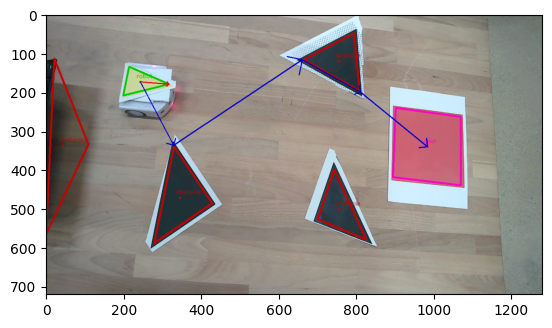

In [10]:
# execute dijkstra
start = [robot[0],robot[1]]
path = compute_shortest_path(obst, start, goal)
path = np.rint(path).astype(int)

print("path")
for p in path:
    print(p)

draw_path(frame, path)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


## Kalman Setup

In [11]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
filter = kalman_filter(robot[0], 0, robot[0], 0, robot[2], 0)
print("Initial state: ", filter.x)

Initial state:  [243.00 0.00 243.00 0.00 0.08 0.00]


## Global Navigation

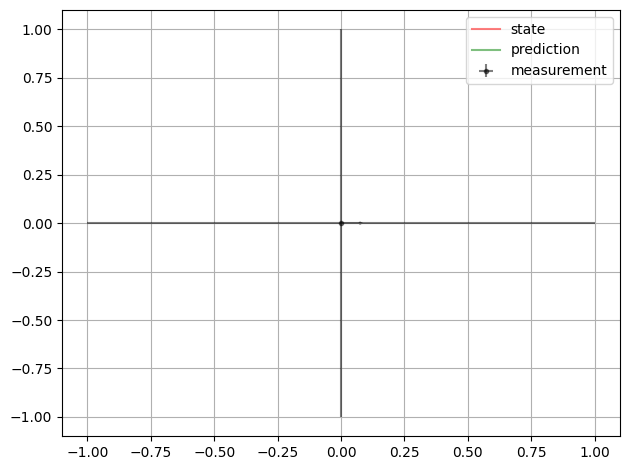

In [12]:
# number of steps
N = 10
cnt = 0
# time step
dt = 0.1
# cv update period
cv_period = 1

# set goal position
set_target(robot[0], robot[1])
set_position(robot[0], robot[1])

fig, ax = plt.subplots()
robot_center = []
while(cnt < N):
    arrived = get_arrive()
    if arrived == 0:
        # update the robot position with the kalman filter prediction
        filter.predict(dt)
        set_position(filter.x[0], filter.x[1])
        robot_center, robot_contour, _ = computer_vision('goal', False)
        
    time.sleep(cv_period)
    # update kalman with the new position
    if robot_center != []:
        filter.update(robot_center[0], robot_center[1])
    cnt += 1
    filter.plot(1,1, fig, ax)
plt.show()